In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
#load signal, backgound data
vbf_events = pd.read_hdf("../MC_Prod_v12/vbf_events.hdf", "vbf")
ggf_events = pd.read_hdf("../MC_Prod_v12/ggF_events.hdf", "ggF")

In [3]:
vbf_events["class"] = 1
ggf_events["class"] = 0

In [4]:
data = pd.concat([vbf_events, ggf_events])
#print data.isnull().values.any()
#data.describe()
data = data.sample(frac=1).reset_index(drop=True) #shuffle the events
target = data["class"]
mass = data["m4l_fsr"]
weights = data["weight_couplings"]
del data["class"]
del data["m4l_fsr"]
del data["weight_couplings"]

In [5]:
mass = mass.apply(np.log)
mass_max, mass_min = mass.max(), mass.min()
mass = (mass - mass_min)/(mass_max - mass_min) #!!! save max, min values to file
#mass.describe()
#plt.hist(mass)
#plt.show()

In [6]:
data.head(5)

,dijet_invmass,dijet_deltaeta,eta_zepp_ZZ,min_dR_jZ,leading_jet_width,subleading_jet_width,jet_pt[0],jet_pt[1],"max(50,pt4ljj_unconstrained)"
0,275.165192,2.249938,0.855028,1.830836,0.069673,0.128648,148.230591,50.234039,50.000000
1,306.585358,3.753342,0.349382,2.913839,0.134385,0.176931,59.516594,36.014366,50.000000
2,813.345398,1.120327,1.948273,2.404872,0.036745,0.042275,609.243652,350.799347,320.723480
3,523.392883,2.749168,1.618853,2.182315,0.107209,0.047531,186.432465,83.778938,130.151352
4,570.634155,2.044327,2.329058,0.913948,0.049197,0.049236,318.720795,134.425095,121.995338


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test, mass_train, mass_test, weights_train, weights_test = \
    train_test_split(data, target, mass, weights, train_size=0.75)
#reset index for dataseries, not needed for ndarray (X_train, X_test)
y_train, y_test, mass_train, mass_test, weights_train, weights_test = \
 y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    mass_train.reset_index(drop=True), mass_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model


#@TODO: check other activations in Andreas, Gilles pivot
inputs = Input(shape=(X_train.shape[1],))
Dx = Dense(32, activation="relu")(inputs)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])
D.compile(loss="binary_crossentropy", optimizer="adam")

Using TensorFlow backend.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  if sys.path[0] == '':


In [9]:
#weights_train.isnull().any()

In [10]:
#weights_train *=1000000

In [11]:
#weights_train.describe()

In [12]:
#(weights_train ==0).any()

In [13]:
def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    from collections import Counter
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority) / count for cls, count in counter.items()}

In [14]:
#D.fit(X_train, y_train, sample_weight=weights_train, nb_epoch=10) #nan loss
#D.fit(X_train, y_train, nb_epoch=10) #unweighted training !!! @TODO: weighted
D.fit(X_train, y_train, nb_epoch=10, class_weight=get_class_weights(y_train)) #unweighted training !!! @TODO: weighted

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
72115/72115 [==============================] - 5s - loss: 0.7595     
Epoch 2/10
72115/72115 [==============================] - 5s - loss: 0.7333     
Epoch 3/10
72115/72115 [==============================] - 4s - loss: 0.7290     
Epoch 4/10
72115/72115 [==============================] - 4s - loss: 0.7263     
Epoch 5/10
72115/72115 [==============================] - 4s - loss: 0.7234     
Epoch 6/10
72115/72115 [==============================] - 4s - loss: 0.7235     
Epoch 7/10
72115/72115 [==============================] - 4s - loss: 0.7205     
Epoch 8/10
72115/72115 [==============================] - 4s - loss: 0.7188     
Epoch 9/10
72115/72115 [==============================] - 4s - loss: 0.7183     
Epoch 10/10
72115/72115 [==============================] - 4s - loss: 0.7168     


In [15]:
from sklearn.metrics import roc_auc_score
y_pred = D.predict(X_test)
y_pred = y_pred.ravel()
roc_auc_score(y_true=y_test, y_score=y_pred, sample_weight=weights_test)
#roc_auc_score(y_true=y_test, y_score=y_pred)

0.8914138182491973

In [16]:
mass_test.describe()

count    24039.000000
mean         0.183682
std          0.143321
min          0.000019
25%          0.071099
50%          0.151144
75%          0.264549
max          1.000000
Name: m4l_fsr, dtype: float64

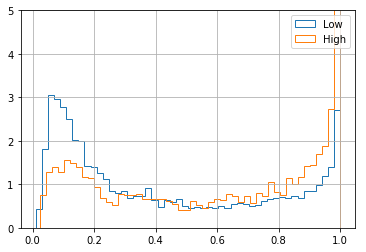

In [17]:
plt.hist(y_pred[mass_test<mass_test.mean()], weights=weights_test[mass_test<mass_test.mean()], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[mass_test>=mass_test.mean()], weights=weights_test[mass_test>=mass_test.mean()], bins=50, histtype="step", normed=1, label="High")
#plt.hist(y_pred[mass_test<mass.mean()], bins=50, histtype="step", normed=1, label="Low")
#plt.hist(y_pred[mass_test>=mass.mean()], bins=50, histtype="step", normed=1, label="High")


plt.ylim(0, 5)
plt.legend()
plt.grid()
plt.show()# @TODO: do sep for signal background, plot mass : full mass dist, vs after cut on bdt

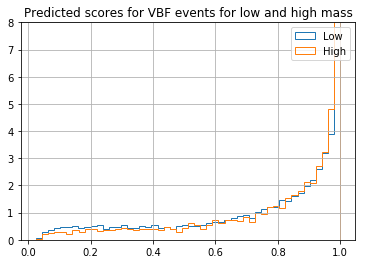

In [18]:
signal_low = list (set( np.where(y_test==1)[0] ) & set( np.where(mass_test<mass_test.mean())[0]))
signal_high = list (set( np.where(y_test==1)[0] ) & set( np.where(mass_test>=mass_test.mean())[0]))

plt.hist(y_pred[signal_low], weights=weights_test[signal_low], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[signal_high], weights=weights_test[signal_high], bins=50, histtype="step", normed=1, label="High")

plt.title("Predicted scores for VBF events for low and high mass")
plt.ylim(0, 8)
plt.legend()
plt.grid()
plt.show()

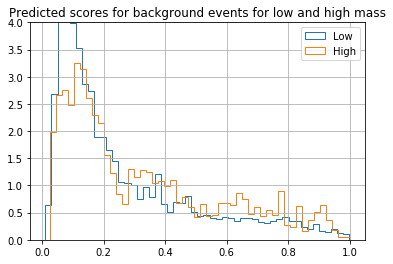

In [19]:
bkg_low = list (set( np.where(y_test==0)[0] ) & set( np.where(mass_test<mass_test.mean())[0]))
bkg_high = list (set( np.where(y_test==0)[0] ) & set( np.where(mass_test>=mass_test.mean())[0]))

plt.hist(y_pred[bkg_low], weights=weights_test[bkg_low], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[bkg_high], weights=weights_test[bkg_high], bins=50, histtype="step", normed=1, label="High")

plt.title("Predicted scores for background events for low and high mass")
plt.ylim(0, 4)
plt.legend()
plt.grid()
plt.show()

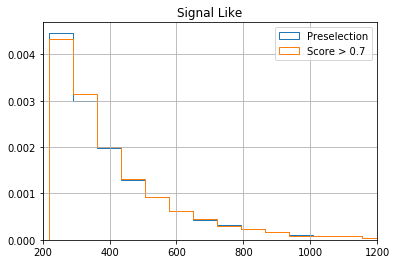

In [20]:
def getGevMass(mass):
    return np.exp (mass * (mass_max - mass_min) + mass_min)
threshold = 0.7
plt.hist(getGevMass(mass_test[y_test==1]), weights=weights_test[y_test==1], bins=50, histtype="step", normed=1, label="Preselection")
plt.hist(getGevMass(mass_test[y_pred > threshold]), weights=weights_test[y_pred > threshold], bins=50, histtype="step", normed=1, label="Score > " + str(threshold))

plt.title("Signal Like")
#plt.ylim(0, 4)
plt.xlim(200, 1200)
plt.legend()
plt.grid()
plt.show()

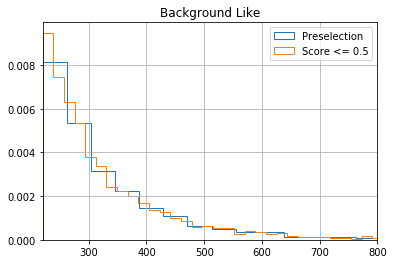

In [21]:
plt.hist(getGevMass(mass_test[y_test==0]), weights=weights_test[y_test==0], bins=50, histtype="step", normed=1, label="Preselection")
plt.hist(getGevMass(mass_test[y_pred <= 0.5]), weights=weights_test[y_pred <= 0.5], bins=120, histtype="step", normed=1, label="Score <= 0.5")

plt.title("Background Like")
#plt.ylim(0, 4)
plt.xlim(220,800 )
plt.legend()
plt.grid()
plt.show()

In [22]:
from scipy.stats import pearsonr
corr = pearsonr(mass_test, y_pred)
print "Unweighted correlation with mass is", corr

Unweighted correlation with mass is (0.17144719, 5.649142876284422e-158)


In [23]:
(y_pred>0.5).sum()/float(y_pred.shape[0]) # much better than without class_weight training

0.72582054161986775

# Now with Adversarial Network

In [36]:
def make_trainable(network, flag):
    network.trainable = flag
    for l in network.layers:
        l.trainable = flag

inputs = Input(shape=(X_train.shape[1],))

Dx = Dense(32, activation="relu")(inputs)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

#@TODO: Gradient reversal layer, and simul training
#@TODO: loss on only the signal, we want that to be flat
Rx = Dx
Rx = Dense(32, activation="relu")(Rx)
Rx = Dense(32, activation="relu")(Rx)
Rx = Dense(32, activation="relu")(Rx)
Rx = Dense(1, activation="sigmoid")(Rx) #try regression activations @TODO ask andreas !!!
R = Model(input=[inputs], outputs=[Rx])
#@TODO: loss only on background events, tanh activation, batch norm, drop out, see Andreas


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  if sys.path[0] == '':
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [37]:
from keras.optimizers import SGD
from keras.losses import mean_squared_error

lam = 1000 #10.0 # pivotal trade-off

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * mean_squared_error(z_pred, z_true)
    return loss_R

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

# Train D such that R loss (its c=-lam) is also minimised, make it invariant to R
#can we train simultaneous? grad reversal layer???
opt_DRf = SGD(momentum=0.0)
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
make_trainable(R, False)
make_trainable(D, True)
DRf.compile(loss=[make_loss_D(c=1.0), make_loss_R(c=-lam)], optimizer=opt_DRf)

opt_DfR = SGD(momentum=0.0)
DfR = Model(input=[inputs], output=[R(inputs)])
make_trainable(R, True)
make_trainable(D, False)
DfR.compile(loss=[make_loss_R(c=1.0)], optimizer=opt_DfR)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [38]:
# Pretrain D
make_trainable(R, False)
make_trainable(D, True)
D.fit(X_train, y_train, nb_epoch=15, class_weight=get_class_weights(y_train))

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Epoch 1/15
72115/72115 [==============================] - 3s - loss: 5.8411     
Epoch 2/15
72115/72115 [==============================] - 3s - loss: 5.6268     
Epoch 3/15
72115/72115 [==============================] - 3s - loss: 5.5091     
Epoch 4/15
72115/72115 [==============================] - 3s - loss: 5.6255     
Epoch 5/15
72115/72115 [==============================] - 3s - loss: 5.5745     
Epoch 6/15
72115/72115 [==============================] - 3s - loss: 5.5546     
Epoch 7/15
72115/72115 [==============================] - 3s - loss: 5.5456     
Epoch 8/15
72115/72115 [==============================] - 3s - loss: 5.4743     
Epoch 9/15
72115/72115 [==============================] - 3s - loss: 5.5116     
Epoch 10/15
72115/72115 [==============================] - 3s - loss: 5.4724     
Epoch 11/15
72115/72115 [==============================] - 3s - loss: 5.4813     
Epoch 12/15
72115/72115 [==============================] - 3s - loss: 5.4617     
Epoch 13/15
72115/72115 [

In [39]:
# Pretrain R
make_trainable(R, True)
make_trainable(D, False)
DfR.fit(X_train, mass_train, nb_epoch=7)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Epoch 1/7
72115/72115 [==============================] - 3s - loss: 0.0280     
Epoch 2/7
72115/72115 [==============================] - 3s - loss: 0.0216     
Epoch 3/7
72115/72115 [==============================] - 3s - loss: 0.0207     
Epoch 4/7
72115/72115 [==============================] - 3s - loss: 0.0203     
Epoch 5/7
72115/72115 [==============================] - 3s - loss: 0.0202     
Epoch 6/7
72115/72115 [==============================] - 3s - loss: 0.0201     
Epoch 7/7
72115/72115 [==============================] - 3s - loss: 0.0201     


In [40]:
def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    plt.grid()
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    plt.grid()
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    plt.grid()
    
    plt.show()

In [41]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

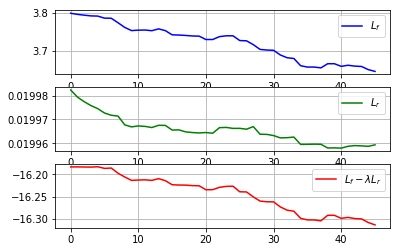

DRf
DfR
Epoch 1/1
72115/72115 [==============================] - 0s - loss: 0.0201     
(3.6453464696022402, 0.019959107094345813, 19.959107094345814)
DRf
DfR
Epoch 1/1
72115/72115 [==============================] - 0s - loss: 0.0201     
(3.6369216014345214, 0.019959237740625881, 19.959237740625881)
DRf
DfR
Epoch 1/1
72115/72115 [==============================] - 0s - loss: 0.0201     
(3.6385111103905254, 0.019959518357557833, 19.959518357557833)
DRf
DfR
Epoch 1/1
72115/72115 [==============================] - 0s - loss: 0.0201     
(3.6331201565186806, 0.019958191906594067, 19.958191906594067)
DRf
DfR
Epoch 1/1
72115/72115 [==============================] - ETA: 0s - loss: 0.020 - 0s - loss: 0.0201     


In [42]:
batch_size = 128
training_iterations = 50#201
for i in range(training_iterations):
    l = DRf.evaluate(X_test, [y_test, mass_test], verbose=0) #add weight!!!   
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0]) # why none, 0? just do l[1]??
    losses["L_r"].append(-l[2][None][0])
    print(losses["L_f"][-1], losses["L_r"][-1] / lam, losses["L_r"][-1])
    
    if i % 5 == 0:
        plot_losses(i, losses)

    # Fit D
    make_trainable(R, False)
    make_trainable(D, True)
    indices = np.random.permutation(len(X_train))[:batch_size]
    print "DRf"
    DRf.train_on_batch(X_train[indices], [y_train[indices], mass_train[indices]], class_weight=get_class_weights(y_train[indices]))
        
    # Fit R
    make_trainable(R, True)
    make_trainable(D, False)
    print "DfR"
    DfR.fit(X_train, mass_train, batch_size=batch_size, nb_epoch=1, verbose=1)
    #@TODO: ask andreas grand reversal layer

In [43]:
y_pred_dc = D.predict(X_test)
y_pred_dc = y_pred_dc.ravel()
roc_auc_score(y_test, y_pred_dc, sample_weight=weights_test)

0.8582335979082526

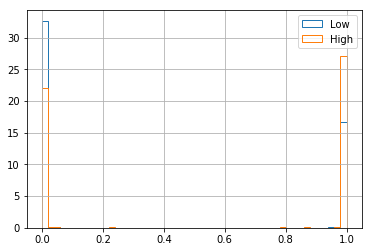

In [44]:
plt.hist(y_pred_dc[mass_test<mass_test.mean()], weights=weights_test[mass_test<mass_test.mean()], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred_dc[mass_test>=mass_test.mean()], weights=weights_test[mass_test>=mass_test.mean()], bins=50, histtype="step", normed=1, label="High")


#plt.ylim(0, 5)
plt.legend()
plt.grid()
plt.show()# @TODO: do sep for signal background, plot mass : full mass dist, vs after cut on bdt

In [45]:
from scipy.stats import pearsonr
corr = pearsonr(mass_test, y_pred_dc)
print "Unweighted correlation with mass is", corr

Unweighted correlation with mass is (0.16856734, 1.0528989778919418e-152)


In [46]:
y_pred_dc

array([ 1.,  1.,  0., ...,  1.,  1.,  1.], dtype=float32)

In [47]:
# add real background, only makes sense to compare after adding bakground to get mass sculpting
# why is the loss so different for the 2 Ds?
# why is the loss decreasing further on pivot training, its not actually.. auc is worse
# why are predictions exactly 0, 1?
# @TODO: do pivot on signal only, not background. see how Andreas did it
# loss of r is changing at a lower level, maybe subtract off the first loss? Ask Gilles,
#saw same in GAN, maybe different activation???